In [60]:
import os
import pandas as pd
import sqlalchemy as sql
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import scipy.optimize as sco

# https://pypi.org/project/yfinance/
import yfinance as yf

import plotly.graph_objects as go
import hvplot.pandas
import holoviews as hv
import seaborn as sns
import copy
import warnings

from pathlib import Path
# https://pandas-datareader.readthedocs.io/en/latest/
from pandas_datareader import data as pdr
from pandas import Timestamp as tstamp
from pandas import read_csv as rcsv
from pandas import read_sql_query as rsqq
from sqlalchemy import (
    create_engine as ce,
    inspect
)

# Import date and timedelta class
from datetime import date
from datetime import timedelta
from scipy import stats

from MCForecastTools import MCSimulation
from calculations import MPTCalculations as mpt
from metrics import QuantMetrics as qm
from dataset import DataCollection as ds

warnings.filterwarnings('ignore')

print(f"Package imports and dependencies resolved")

Package imports and dependencies resolved


### Modern Portfolio Theory Based Portfolio Analysis and Optimization

---
Steps Involved:
1. Project Settings
2. Data Preparation (Data Collection, Clean and Format)
3. Quantitative Analysis
4. Visualizations

### 1. Project Settings
- Define the time delta (time-frame) to start with in the historical time reference.

In [61]:
# Specifiy date range for data
# Set start and end dates of 5 years "5Y" back from your current date
# Define the time delta (time-frame) to start with
time_delta = 5

end_date = pd.to_datetime('today')
# 5 years
start_date = end_date - np.timedelta64(time_delta, 'Y')
start, end = start_date, end_date
# Verify date range
print(f"Start date: {start} and End date: {end}")

Start date: 2017-10-19 19:14:42.763316 and End date: 2022-10-20 00:20:42.763316


### Add or remove stocks of possible sectors
- tech_list or others to evaluate the asset performance
- refer to dataset.py for the entire sector list

In [62]:
# Specify portfolio sectors - basket of market index and assets - S&P 500 Index (^GSPC) and Tech Stocks List
basket_list = ds.market + ds.tech_list

print("Basket of stocks")
print(basket_list)

Basket of stocks
['^GSPC', 'AAPL', 'IBM', 'TSLA', 'GOOGL', 'MSFT', 'CSCO', 'TSM', 'NVDA']


### 2. Data Preparation

In [63]:
# Dataframe closing prices of basket, i.e. market index and assets
# Fetch data from Yahoo Finance API
stock_data, raw_data = ds.get_raw_data(basket_list, start, end)
stock_data.rename(columns = {'^GSPC':'SP500_index'}, inplace = True)
stock_data = stock_data.reset_index()
raw_data.rename(columns = {'^GSPC':'SP500_index'}, inplace = True)

In [64]:
# Output raw data is raw_frame_close
display(raw_data.shape)
# Review random 5 rows from dataframe
display(raw_data.sample(5))

(1258, 54)

Attributes    Adj Close                                                  \
Symbols     SP500_index        AAPL         IBM        TSLA       GOOGL   
Date                                                                      
2022-10-05  3783.280029  146.399994  125.739998  240.809998  101.430000   
2021-10-01  4357.040039  141.855103  130.359879  258.406677  136.542999   
2020-08-17  3381.989990  113.240524  107.642296  122.375999   75.811996   
2020-01-13  3288.129883   77.758415  113.900833   34.990665   72.001503   
2021-02-05  3886.830078  135.564194  106.877632  284.076660  104.441498   

Attributes                                                       Close  ...  \
Symbols           MSFT       CSCO         TSM        NVDA  SP500_index  ...   
Date                                                                    ...   
2022-10-05  249.199997  41.990002   74.480003  132.089996  3783.280029  ...   
2021-10-01  286.698883  53.103161  109.369293  207.253876  4357.040039  ...   
2020-08-17  206.139130  39.284157   76.977875  123.105484  3381.989990  ...   
2020-01-13  159.185287  44.005028   56.688557   62.793697  3288.129883  ...   
2021-02-05  238.627594  45.656052  123.815086  135.699234  3886.830078  ...   

Attributes        Open        Volume                                       \
Symbols           NVDA   SP500_index         AAPL        IBM         TSLA   
Date                                                                        
2022-10-05  129.110001  4.293180e+09   79471000.0  3212900.0   86982700.0   
2021-10-01  207.500000  3.148980e+09   94639600.0  6907889.0   51094200.0   
2020-08-17  118.512497  3.671290e+09  119561600.0  3514665.0  303634500.0   
2020-01-13   61.915001  3.456380e+09  121532000.0  3693426.0  397764000.0   
2021-02-05  137.250000  4.838580e+09   75693800.0  4775722.0   55699800.0   

Attributes                                                              
Symbols          GOOGL        MSFT        CSCO         TSM        NVDA  
Date                                                                    
2022-10-05  22176900.0  20347100.0  14289700.0  14037100.0  50713100.0  
2021-10-01  35360000.0  30086300.0  18338000.0   5315200.0  24097800.0  
2020-08-17  19990000.0  20184800.0  30511700.0   8663900.0  62130000.0  
2020-01-13  30730000.0  21626500.0  18237400.0   6613700.0  31984000.0  
2021-02-05  29866000.0  18054800.0  25488600.0   6226800.0  16915200.0  

[5 rows x 54 columns]

In [65]:
# Output cleaned data to 'Close' prices is stock_data, cut table down to 29 columns from 174 columns
display(stock_data.shape)
print("Review random 5 rows from dataframe")
# Review random 5 rows from dataframe
display(stock_data.sample(5))

(1258, 10)

Review random 5 rows from dataframe


Symbols,Date,SP500_index,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
162,2018-06-14,2782.489990,47.700001,138.814529,23.848000,58.005501,101.419998,44.689999,38.599998,66.727501
73,2018-02-06,2695.139893,40.757500,148.508606,22.264668,54.221500,91.330002,40.169998,43.590000,56.395000
807,2021-01-06,3748.139893,126.599998,123.604210,251.993332,86.143997,212.250000,44.400002,115.610001,126.144997
481,2019-09-20,2992.070068,54.432499,135.640533,16.041332,61.492001,139.440002,49.599998,43.869999,43.172501
426,2019-07-03,2995.820068,51.102501,135.315491,15.660000,56.149502,137.460007,56.480000,40.330002,40.687500


In [66]:
# Import the [offline stored] data from the csv file
# Generate dataframe setting the DatetimeIndex with 'date' as as index. 
working_raw_data = rcsv(
    Path('data/raw_frame_close.csv'),
    index_col=0,
    parse_dates=True,
    infer_datetime_format=True,
    header = [0,1]
)

# Output dataframe name is working_raw_frame_close
print('Sample row of DataFrame from local csv data source path:')
display(working_raw_data.shape)

# Display sample 5 rows of dataframe
display(working_raw_data.sample(5))

Sample row of DataFrame from local csv data source path:


(1258, 54)

Attributes    Adj Close                                                 \
Symbols           ^GSPC        AAPL         IBM        TSLA      GOOGL   
Date                                                                     
2018-11-26  2673.449951   42.204643   95.129723   23.066668  52.797001   
2019-05-24  2826.060059   43.608822  107.741699   12.708667  56.930500   
2018-07-10  2793.840088   45.686302  112.477554   21.497999  58.356998   
2018-08-13  2821.929932   50.307140  112.121384   23.760668  62.431999   
2020-12-03  3666.719971  121.683212  108.474777  197.793335  91.092003   

Attributes                                                      Close  ...  \
Symbols           MSFT       CSCO        TSM        NVDA        ^GSPC  ...   
Date                                                                   ...   
2018-11-26  102.287537  40.358089  33.204285   37.953884  2673.449951  ...   
2019-05-24  122.249725  48.831688  34.430061   36.067959  2826.060059  ...   
2018-07-10   97.311935  37.703140  34.186710   62.767494  2793.840088  ...   
2018-08-13  103.115173  38.486050  36.692360   63.478828  2821.929932  ...   
2020-12-03  211.080002  41.549236  96.007523  133.752258  3666.719971  ...   

Attributes      Open        Volume                                       \
Symbols         NVDA         ^GSPC         AAPL        IBM         TSLA   
Date                                                                      
2018-11-26   37.4725  3.443950e+09  179994000.0  5241611.0  119881500.0   
2019-05-24   37.0200  2.887390e+09   94858800.0  2715521.0  212049000.0   
2018-07-10   62.4375  3.063850e+09   63756400.0  3950742.0  142072500.0   
2018-08-13   63.7850  3.158450e+09  103563600.0  2989991.0  156958500.0   
2020-12-03  135.8750  5.091760e+09   78967600.0  4757417.0  127656000.0   

Attributes                                                              
Symbols          GOOGL        MSFT        CSCO         TSM        NVDA  
Date                                                                    
2018-11-26  31558000.0  32336200.0  18275900.0   7077300.0  81483200.0  
2019-05-24  18554000.0  14123400.0  13057600.0  10540700.0  35758400.0  
2018-07-10  21334000.0  19293100.0  20224600.0   7211500.0  36001600.0  
2018-08-13  27500000.0  18472500.0  18113200.0   6708600.0  37520800.0  
2020-12-03  24728000.0  25120900.0  27710700.0   7359000.0  19952000.0  

[5 rows x 54 columns]

In [67]:
# Verify Close columns of each stocks and index
working_raw_data['Close']

Symbols,^GSPC,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
Date,,,,,,,,,
2017-10-20,2575.209961,39.062500,154.942642,23.006666,50.253502,78.809998,34.250000,41.119999,49.224998
2017-10-23,2564.979980,39.042500,152.533463,22.468000,49.277000,78.830002,34.349998,41.209999,49.154999
2017-10-24,2569.129883,39.275002,149.024857,22.489332,49.424500,78.860001,34.580002,41.320000,49.669998
2017-10-25,2557.149902,39.102501,146.749527,21.722668,49.573002,78.629997,34.299999,41.160000,48.415001
2017-10-26,2560.399902,39.352501,146.845123,21.744667,49.570999,78.760002,34.270000,41.200001,48.922501
...,...,...,...,...,...,...,...,...,...
2022-10-13,3669.909912,142.990005,121.790001,221.720001,99.059998,234.240005,40.610001,66.620003,119.599998
2022-10-14,3583.070068,138.380005,120.040001,204.990005,96.559998,228.559998,40.200001,63.919998,112.269997
2022-10-17,3677.949951,142.410004,121.519997,219.350006,99.970001,237.529999,41.299999,64.889999,118.879997


### Create 'basket' from SQLite temp db

In [68]:
# Fetch date indexed and unindexed data frames created out of SQLite temp db
sql_basket_indexed_df, sql_basket_df = ds.sqlite_data(stock_data)

print("Unindexed dataframe counts and column summary")
display(sql_basket_df.shape) 
# Display sample 5 rows of unindexed dataframe
display(sql_basket_df.sample(5))

print("Indexed dataframe counts and column summary")
display(sql_basket_indexed_df.shape) 

# Display sample 5 rows of indexed datafarme
display(sql_basket_indexed_df.sample(5))

Unindexed dataframe counts and column summary


(1258, 10)

,Date,SP500_index,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
612,2020-03-30,2626.649902,63.702499,107.963669,33.475334,57.315498,160.229996,40.320000,47.820000,66.397499
768,2020-11-09,3550.500000,116.320000,110.449333,140.419998,88.070999,218.389999,38.200001,89.029999,136.307495
940,2021-07-19,4258.490234,142.449997,131.854691,215.406662,124.578003,277.010010,53.060001,115.349998,187.797501
570,2020-01-29,3273.399902,81.084999,131.634796,38.732666,72.834999,168.039993,47.049999,57.189999,61.384998
365,2019-04-05,2892.739990,49.250000,136.978973,18.330667,60.572498,119.889999,55.209999,42.230000,47.737499


Indexed dataframe counts and column summary


(1258, 9)

,SP500_index,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
Date,,,,,,,,,
2020-06-24,3050.330078,90.014999,111.300194,64.056664,71.635002,197.839996,44.750000,56.580002,92.355003
2022-09-12,4110.410156,163.429993,130.660004,304.420013,110.860001,266.649994,46.400002,82.150002,145.050003
2018-10-25,2705.570068,54.950001,120.889099,20.990667,55.179501,108.300003,45.470001,37.389999,51.959999
2019-11-05,3074.620117,64.282501,131.826004,21.148001,64.571999,144.460007,47.759998,53.549999,52.402500
2021-01-07,3803.790039,130.919998,123.317398,272.013336,88.717003,218.289993,44.959999,121.430000,133.440002


### 3. Quant Analysis

In [69]:
# Display constants being used in quant analysis
print("Number of trading days per year = ", qm.num_trading_days)
print("Risk free rate = ", qm.risk_free_rate)
print("Number of random portfolio runs = ", qm.num_random_portfolio_run)
print("Number of days in rolling window = ", qm.rolling_window_days)
print("Number of days of input dataframe to use as historical data = ", mpt.historical_days_percent)
print("Number of days of input dataframe to use as test/experiment data  = ", mpt.test_days_percent)

Number of trading days per year =  252
Risk free rate =  0.0275
Number of random portfolio runs =  10000
Number of days in rolling window =  20
Number of days of input dataframe to use as historical data =  0.8
Number of days of input dataframe to use as test/experiment data  =  0.19999999999999996


In [70]:
display(sql_basket_indexed_df.shape)

(1258, 9)

In [71]:
# Break up the input asset price data frame into 2 chunks
# (1) For use of historical data to determine what the optimum portfolio selection should be
# (2) For test purposes,test how wll the portfolio allocation performs
num_days_total = sql_basket_indexed_df.shape[0]
num_historical_days_percent = round(num_days_total * mpt.historical_days_percent)
num_test_days_percent = round(num_days_total * mpt.test_days_percent)

print("Total # of days in asset dataframe = ", num_days_total)
print("Total # of days will use for hisotrical data = ", num_historical_days_percent)
print("Total # of days will use for testing results = ", num_test_days_percent)


# Extract the days from full dataframe will use for historical data
asset_mkt_prices_historical_df = sql_basket_indexed_df.iloc[0:num_historical_days_percent-1, :].copy()
asset_mkt_prices_test_df = sql_basket_indexed_df.iloc[num_historical_days_percent:num_days_total-1,:].copy()

Total # of days in asset dataframe =  1258
Total # of days will use for hisotrical data =  1006
Total # of days will use for testing results =  252


In [72]:
# Plot the individual asset prices taking previous 4 years (80% of 5 years period)
asset_mkt_prices_historical_df.drop('SP500_index', axis=1, inplace=False).hvplot.line(
    ylabel="Prices", 
    xlabel="Date",
    width = 800,
    height = 500,
    hover_color = 'magenta',
    title="(In-Test) Performance of Historical Assets Prices"
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [73]:
# Plot the individual asset prices in the next 1 year (20% of 5 years period)
asset_mkt_prices_test_df.drop('SP500_index', axis=1, inplace=False).hvplot.line(
    ylabel="Prices", 
    xlabel="Date",
    width = 800,
    height = 500,
    hover_color = 'magenta',
    title="(Out-of-Test) Assets Prices"
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

#### Calculate Descriptive Stats
---
* Asset Returns, Standard Deviation, Cumulative Returns, Covariance, Correlation Matrix, Sharpe Ratio

In [74]:
# Compute the frequency components on asset prices
asset_mkt_prices_returns_df,        \
asset_mkt_prices_ann_returns_mean,  \
asset_mkt_prices_std_df,            \
asset_mkt_prices_ann_std_df,        \
asset_mkt_prices_std_rolling_df,    \
asset_mkt_prices_ann_cov_mtrx_df,   \
asset_mkt_prices_ann_corr_mtrx_df,  \
asset_mkt_prices_cum_returns_df,    \
asset_prices_sharpe_ratio_df,       \
log_returns                           = qm.mpt_qa_compute_freq_stats(asset_mkt_prices_historical_df)

In [75]:
# Review daily returns DataFrame
print("Asset Returns:")
display(asset_mkt_prices_returns_df.shape)
# Display randow 5 rows of the returns
display(asset_mkt_prices_returns_df.sample(5))

Asset Returns:


(1004, 9)

,SP500_index,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
Date,,,,,,,,,
2018-07-02,0.003068,0.011182,0.001145,-0.022977,0.011442,0.014197,-0.005113,-0.000547,0.022541
2021-01-08,0.005492,0.008631,-0.003566,0.078403,0.013239,0.006093,0.002224,-0.022564,-0.005040
2019-12-12,0.008575,0.002548,0.011663,0.019790,0.003154,0.010152,0.031391,0.048479,0.030965
2020-05-05,0.009041,0.015009,0.007396,0.009222,0.019744,0.010736,0.002660,-0.008437,0.008411
2018-06-19,-0.004023,-0.016160,-0.004014,-0.049295,-0.004132,0.000000,-0.008822,-0.018039,-0.018560


In [76]:
# Plot the distribution of the returns of the individual assets
asset_mkt_prices_returns_df.hvplot.hist(bins=100, subplots=True, width=400, group_label='Ticker', grid=True).cols(3)

:NdLayout   [Default]
   :Histogram   [NVDA]   (NVDA_count)

In [77]:
# Plot the asset cumulative returns
asset_mkt_prices_cum_returns_df.hvplot.line(
    ylabel="Cum Returns", 
    xlabel="Date",
    width = 800,
    height = 500,
    hover_color = 'magenta',
    title="Market & Assets Cumulative Returns"
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

<AxesSubplot:title={'center':'Asset & Market: Daily Returns Box Plot'}>

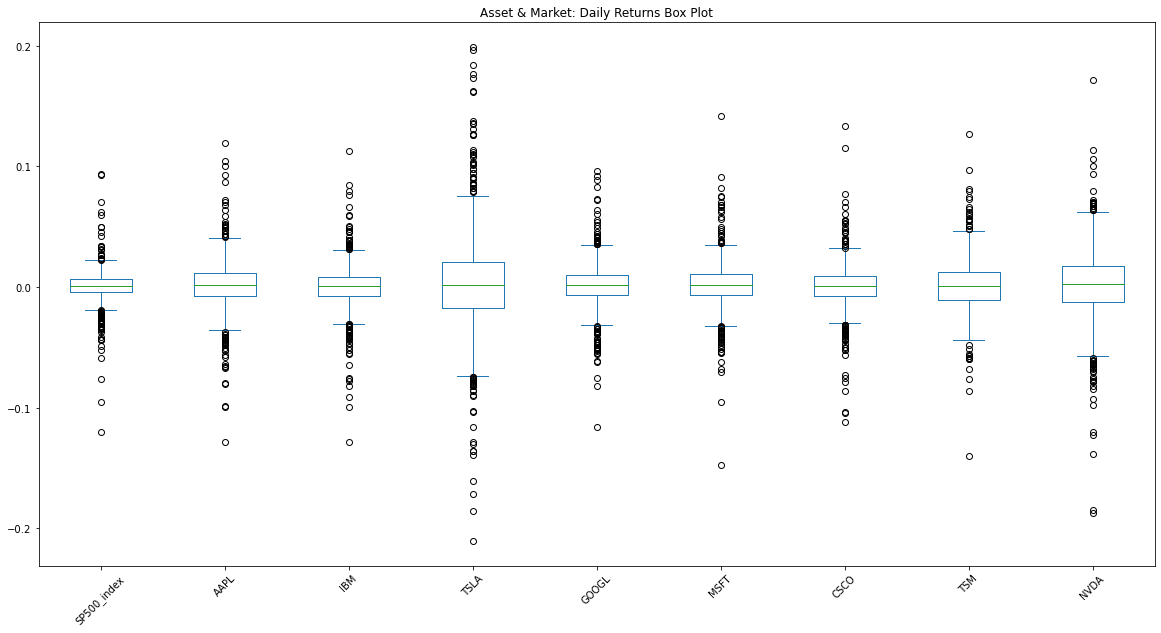

In [78]:
# Use the daily return data to create box plots to visualize the volatility of the assets 
asset_mkt_prices_returns_df.plot.box(figsize=(20, 10), rot=45, title = "Asset & Market: Daily Returns Box Plot")

In [79]:
# Sort the asset deviations
asset_mkt_prices_ann_std_sorted_df = asset_mkt_prices_ann_std_df.sort_values()

print("Asset annualized standard deviations (Sorted):")
display(asset_mkt_prices_ann_std_sorted_df)

Asset annualized standard deviations (Sorted):


SP500_index    0.210826
IBM            0.280612
CSCO           0.290152
GOOGL          0.290368
MSFT           0.298004
AAPL           0.327054
TSM            0.334193
NVDA           0.472639
TSLA           0.639292
dtype: float64

In [80]:
# Dispaly the (sorted) asset sharpe ratios
print("Assets & Market: Annual Sharpe Ratio (Sorted):")
display(asset_prices_sharpe_ratio_df.sort_values())

asset_prices_sharpe_ratio_df.hvplot(
    kind = 'bar',
    width = 800,
    height = 500,
    hover_color = 'magenta',
    rot = 45,
    title = "Assets & Market: Annual Sharpe Ratio")

Assets & Market: Annual Sharpe Ratio (Sorted):


IBM            0.024990
CSCO           0.558185
SP500_index    0.767164
TSM            0.941915
NVDA           1.040046
GOOGL          1.048396
AAPL           1.179032
MSFT           1.295872
TSLA           1.313903
dtype: float64

:Bars   [index]   (0)

In [81]:
# Drop the market from asset/mkt data frame
asset_prices_df = asset_mkt_prices_historical_df.drop(['SP500_index'], axis=1, inplace=False)
print("Asset Prices DataFrame (does not include market)")
display(asset_prices_df)

market_df = pd.DataFrame(asset_mkt_prices_returns_df['SP500_index'])

# Recompute frequence components (e.g. covariance matrix will be different).
asset_mkt_prices_returns_df,        \
asset_mkt_prices_ann_returns_mean,  \
asset_mkt_prices_std_df,            \
asset_mkt_prices_ann_std_df,        \
asset_mkt_prices_std_rolling_df,    \
asset_mkt_prices_ann_cov_mtrx_df,   \
asset_mkt_prices_ann_corr_mtrx_df,  \
asset_mkt_prices_cum_returns_df,    \
asset_prices_sharpe_ratio_df,       \
log_returns                           = qm.mpt_qa_compute_freq_stats(asset_prices_df)

Asset Prices DataFrame (does not include market)


,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
Date,,,,,,,,
2017-10-20,39.062500,154.942642,23.006666,50.253502,78.809998,34.250000,41.119999,49.224998
2017-10-23,39.042500,152.533463,22.468000,49.277000,78.830002,34.349998,41.209999,49.154999
2017-10-24,39.275002,149.024857,22.489332,49.424500,78.860001,34.580002,41.320000,49.669998
2017-10-25,39.102501,146.749527,21.722668,49.573002,78.629997,34.299999,41.160000,48.415001
2017-10-26,39.352501,146.845123,21.744667,49.570999,78.760002,34.270000,41.200001,48.922501
...,...,...,...,...,...,...,...,...
2021-10-12,141.509995,134.292542,268.573334,136.449005,292.880005,54.279999,109.199997,206.710007
2021-10-13,140.910004,134.569794,270.359985,137.582001,296.309998,54.619999,109.980003,209.389999
2021-10-14,143.759995,137.084137,272.773346,141.151001,302.750000,55.650002,112.559998,217.460007


In [82]:
print("Annual Covariance Matrix:")
display(asset_mkt_prices_ann_cov_mtrx_df.head())

print("Correlation Matrix:")
display(asset_mkt_prices_ann_corr_mtrx_df)

Annual Covariance Matrix:


,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
AAPL,0.106964,0.043487,0.087606,0.064136,0.073788,0.057527,0.061518,0.099033
IBM,0.043487,0.078743,0.041615,0.041519,0.045318,0.051412,0.041252,0.055929
TSLA,0.087606,0.041615,0.408694,0.069101,0.081925,0.051225,0.077508,0.125888
GOOGL,0.064136,0.041519,0.069101,0.084313,0.068377,0.049839,0.051519,0.087514
MSFT,0.073788,0.045318,0.081925,0.068377,0.088806,0.058345,0.057168,0.098662


Correlation Matrix:


,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
AAPL,1.000000,0.473839,0.419001,0.675357,0.757085,0.606214,0.562841,0.640664
IBM,0.473839,1.000000,0.231975,0.509559,0.541932,0.631444,0.439891,0.421701
TSLA,0.419001,0.231975,1.000000,0.372253,0.430029,0.276159,0.362786,0.416633
GOOGL,0.675357,0.509559,0.372253,1.000000,0.790202,0.591550,0.530906,0.637677
MSFT,0.757085,0.541932,0.430029,0.790202,1.000000,0.674775,0.574030,0.700484
CSCO,0.606214,0.631444,0.276159,0.591550,0.674775,1.000000,0.483374,0.547394
TSM,0.562841,0.439891,0.362786,0.530906,0.574030,0.483374,1.000000,0.622841
NVDA,0.640664,0.421701,0.416633,0.637677,0.700484,0.547394,0.622841,1.000000


[Text(0.5, 1.0, 'Asset Prices Correlation Matrix')]

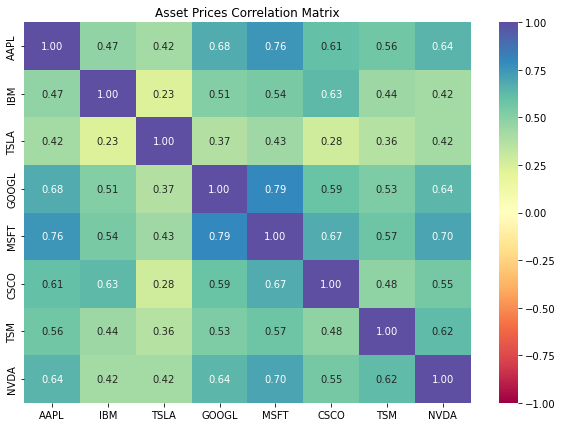

In [83]:
# Use the `heatmap` function from the seaborn library to visualize the correlation matrix
plt.figure(figsize = (10,7))
sns.heatmap(
    asset_mkt_prices_ann_corr_mtrx_df, 
    annot=True, 
    vmin=-1, 
    vmax=1, 
    fmt=".2f", 
    cmap="Spectral"
).set(
    title='Asset Prices Correlation Matrix')

In [84]:
print("Annual average asset returns:")
display(asset_mkt_prices_ann_returns_mean)

Annual average asset returns:


AAPL     0.385607
IBM      0.007013
TSLA     0.839968
GOOGL    0.304420
MSFT     0.386175
CSCO     0.161959
TSM      0.314781
NVDA     0.491567
dtype: float64

### Efficient Frontier Computation

In [85]:
# Determine the efficient frontier components
efficient_frontier_df = qm.mpt_qa_get_efficient_frontier(asset_prices_df, asset_mkt_prices_ann_returns_mean, asset_mkt_prices_ann_cov_mtrx_df)

print("Efficient Frontier DataFrame:")
display(efficient_frontier_df.shape)

print("Print random 5 rows of Efficient Frontier sample points")
display(efficient_frontier_df.sample(5))

Efficient Frontier DataFrame:


(10000, 11)

Print random 5 rows of Efficient Frontier sample points


,Returns,Volatility,SharpeRatio,AAPL_W,IBM_W,TSLA_W,GOOGL_W,MSFT_W,CSCO_W,TSM_W,NVDA_W
8980,0.361152,4.404294,0.075756,0.110232,0.042905,0.046543,0.218684,0.166444,0.038003,0.244175,0.133015
6374,0.316852,4.119828,0.070234,0.192909,0.173626,0.031263,0.180404,0.357185,0.001787,0.051135,0.011693
9292,0.495517,5.328564,0.087832,0.106220,0.014841,0.324312,0.103354,0.068287,0.055657,0.258561,0.068767
8222,0.357189,4.529296,0.072790,0.043918,0.026269,0.001867,0.235270,0.250589,0.010975,0.246561,0.184550
4604,0.444847,5.023938,0.083072,0.212121,0.070324,0.183813,0.024936,0.091425,0.038836,0.153323,0.225223


In [86]:
# Select the following portfolio allocations:
# (1) Based on the "minimum" risk
# (2) Based on the "maximum" risk
# (3) Based on the "optimum sharpe ratio"
portfolio_min_volatility, portfolio_max_volatility, portfolio_opt_sharpe_ratio = qm.mpt_qa_return_portfolio_allocations(efficient_frontier_df)

print("Efficient Frontier: Min Volatility Point:")
display(portfolio_min_volatility)
print("\nEfficient Frontier: Max Volatility Point:")
display(portfolio_max_volatility)
print("\nEfficient Frontier: Opt Sharpe Ratio Volatility Point:")
display(portfolio_opt_sharpe_ratio)

Efficient Frontier: Min Volatility Point:


Returns        0.211824
Volatility     3.842909
SharpeRatio    0.047965
AAPL_W         0.032614
IBM_W          0.338790
TSLA_W         0.043756
GOOGL_W        0.287798
MSFT_W         0.061227
CSCO_W         0.176045
TSM_W          0.051083
NVDA_W         0.008688
Name: 8629, dtype: float64


Efficient Frontier: Max Volatility Point:


Returns        0.549631
Volatility     6.211447
SharpeRatio    0.084060
AAPL_W         0.010670
IBM_W          0.009084
TSLA_W         0.318036
GOOGL_W        0.068108
MSFT_W         0.011669
CSCO_W         0.053348
TSM_W          0.088511
NVDA_W         0.440575
Name: 3099, dtype: float64


Efficient Frontier: Opt Sharpe Ratio Volatility Point:


Returns        0.496627
Volatility     5.174273
SharpeRatio    0.090665
AAPL_W         0.161628
IBM_W          0.019135
TSLA_W         0.304991
GOOGL_W        0.087620
MSFT_W         0.250867
CSCO_W         0.016766
TSM_W          0.149548
NVDA_W         0.009445
Name: 7655, dtype: float64

In [87]:
# Plot the efficient frontier #3 (Efficient frontier + porfolio selection points + 3rd color dimension of the sharpe ratio points)
scatter = hv.Scatter((efficient_frontier_df['Volatility'], efficient_frontier_df['Returns'], efficient_frontier_df.loc[:,'SharpeRatio']), 'Volatility', ['Return', 'Sharpe Ratio'])
max_sharpe = hv.Scatter([(portfolio_opt_sharpe_ratio[1],portfolio_opt_sharpe_ratio[0])])
min_volatility = hv.Scatter([(portfolio_min_volatility[1],portfolio_min_volatility[0])])
max_volatility = hv.Scatter([(portfolio_max_volatility[1],portfolio_max_volatility[0])])

scatter.opts(title="Efficient Frontier + Min/Max/OptSharpeRatio Selections", color='Sharpe Ratio', cmap='plasma', width=800, height=600, colorbar=True, padding=0.1) *\
max_sharpe.opts(color='blue', line_color='black', size=15,) *\
min_volatility.opts(color='yellow', line_color='black', size=15) *\
max_volatility.opts(color='red', line_color='black', size=15)


:Overlay
   .Scatter.I   :Scatter   [Volatility]   (Return,Sharpe Ratio)
   .Scatter.II  :Scatter   [x]   (y)
   .Scatter.III :Scatter   [x]   (y)
   .Scatter.IV  :Scatter   [x]   (y)

### Visualization for: "mpt_performance_eval.py"

In [88]:
# Select the following portfolio allocations:
# (1) Based on the "minimum volatility" risk
# (2) Based on the "maximum returns" risk
# (3) Based on the "optimum sharpe ratio"
portfolio_min_volatility_returns_df = mpt.mpt_pe_compute_portfolio_returns(asset_mkt_prices_returns_df, portfolio_min_volatility)
portfolio_max_volatility_returns_df = mpt.mpt_pe_compute_portfolio_returns(asset_mkt_prices_returns_df, portfolio_max_volatility)
portfolio_opt_sharpe_ratio_volatility_returns_df = mpt.mpt_pe_compute_portfolio_returns(asset_mkt_prices_returns_df, portfolio_opt_sharpe_ratio)

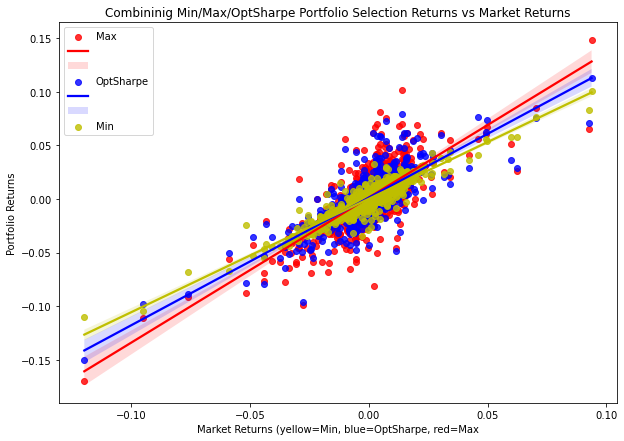

In [89]:
plt.subplots(figsize=(10,7))

x_df = market_df.reset_index(drop=True)
y_df = portfolio_max_volatility_returns_df
z_df = pd.concat([x_df, y_df], axis=1, join="inner")
z_df.columns = ["Market", "MaxVol"]
sns.regplot(x="Market", y="MaxVol", data=z_df, color='r')

y_df = portfolio_opt_sharpe_ratio_volatility_returns_df
z_df = pd.concat([x_df, y_df], axis=1, join="inner")
z_df.columns = ["Market", "OptSharpe"]
sns.regplot(x="Market", y="OptSharpe", data=z_df, color='b')

y_df = portfolio_min_volatility_returns_df
z_df = pd.concat([x_df, y_df], axis=1, join="inner")
z_df.columns = ["Market", "MinReturns"]
sns.regplot(x="Market", y="MinReturns", data=z_df, color='y')

plt.xlabel("Market Returns (yellow=Min, blue=OptSharpe, red=Max")
plt.ylabel("Portfolio Returns")
plt.legend(["Max", "", "", "OptSharpe", "", "", "Min"])
plt.title("Combininig Min/Max/OptSharpe Portfolio Selection Returns vs Market Returns")

plt.show()

<AxesSubplot:title={'center':'Portfolio Composition - Min Protfolio'}, ylabel='weights'>

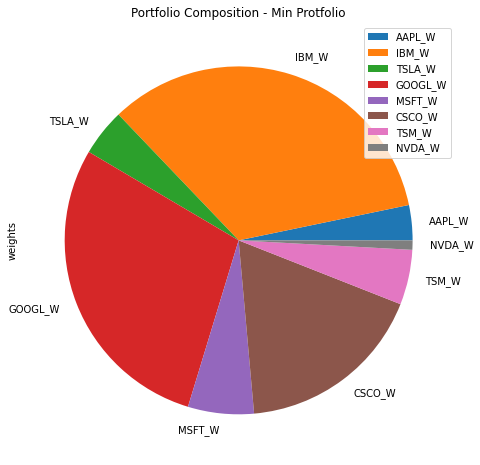

In [90]:
portfolio_min_weights = mpt.mpt_pe_get_portfolio_weights_df(portfolio_min_volatility)

# Plot the pie charts of the porfolio allocation/weights
portfolio_min_weights.plot.pie(
    y='weights', 
    title='Portfolio Composition - Min Protfolio',
    figsize=(10,8))

<AxesSubplot:title={'center':'Portfolio Composition - Max Protfolio'}, ylabel='weights'>

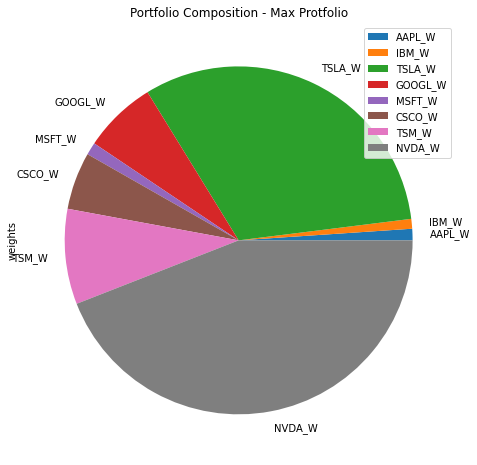

In [91]:
portfolio_max_weights = mpt.mpt_pe_get_portfolio_weights_df(portfolio_max_volatility)

# Plot the pie charts of the porfolio allocation/weights
portfolio_max_weights.plot.pie(y='weights', title='Portfolio Composition - Max Protfolio', figsize=(10,8))

<AxesSubplot:title={'center':'Portfolio Composition - Opt Sharpe Ratio Protfolio'}, ylabel='weights'>

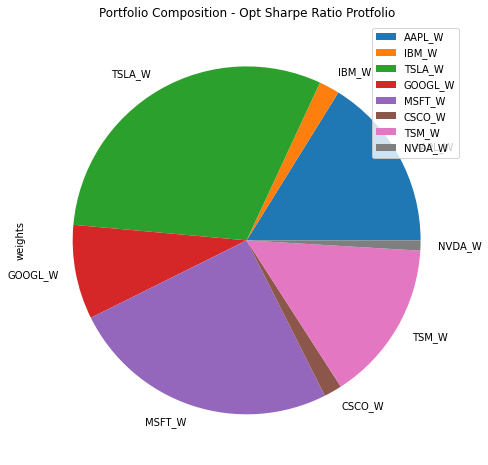

In [92]:
portfolio_opt_sharpe_ratio_weights = mpt.mpt_pe_get_portfolio_weights_df(portfolio_opt_sharpe_ratio)

# Plot the pie charts of the porfolio allocation/weights
portfolio_opt_sharpe_ratio_weights.plot.pie(y='weights', title='Portfolio Composition - Opt Sharpe Ratio Protfolio', figsize=(10,8))

### Compute Actual Realized Portfolio Value under the Test dataframe components

In [93]:
asset_prices_test_beg_df = pd.DataFrame(sql_basket_indexed_df.iloc[num_historical_days_percent, :]).drop('SP500_index', axis=0, inplace=False)
asset_prices_test_end_df = pd.DataFrame(sql_basket_indexed_df.iloc[num_days_total-1, :]).drop('SP500_index', axis=0, inplace=False)

print("Beginning and end dates used for the testing the performance of the portfolio")
display(asset_prices_test_beg_df.T)
display(asset_prices_test_end_df.T)

Beginning and end dates used for the testing the performance of the portfolio


,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
2021-10-20,149.259995,135.659653,288.600006,141.768997,307.410004,56.200001,115.589996,221.029999


,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
2022-10-19,143.860001,122.510002,222.039993,99.629997,236.479996,41.880001,63.66,120.510002


### Monte-Carlo Dataframe Weights List

In [94]:
# Arrange Monte Carlo dataframe weights list
portfolio_mc_min_weights = mpt.mpt_pe_get_mc_weights(portfolio_min_weights)
portfolio_mc_max_weights = mpt.mpt_pe_get_mc_weights(portfolio_max_weights)
portfolio_mc_opt_sharpe_ratio_weights = mpt.mpt_pe_get_mc_weights(portfolio_opt_sharpe_ratio_weights)

In [95]:
investment_pnl_min = mpt.mpt_pe_compute_investment_pnl(mpt.initial_test_investment, asset_prices_test_beg_df, asset_prices_test_end_df, pd.DataFrame(portfolio_mc_min_weights))[0][0]
investment_pnl_max = mpt.mpt_pe_compute_investment_pnl(mpt.initial_test_investment, asset_prices_test_beg_df, asset_prices_test_end_df, pd.DataFrame(portfolio_mc_max_weights))[0][0]
investment_pnl_opt_sharpe_ratio = mpt.mpt_pe_compute_investment_pnl(mpt.initial_test_investment, asset_prices_test_beg_df, asset_prices_test_end_df, pd.DataFrame(portfolio_mc_opt_sharpe_ratio_weights))[0][0]

print("Actual realized portfolio value for min/max/opt_sharpe allocations:")
display(investment_pnl_min)
display(investment_pnl_max)
display(investment_pnl_opt_sharpe_ratio)

Actual realized portfolio value for min/max/opt_sharpe allocations:


7813.030010223389

6503.359966278076

7590.249885559082

### Run Monte-Carlo Simulations
---
* Compute expected Returns, and 
* Compare against realized returns

In [96]:
print("Number of MC runs:", mpt.num_mc_runs)

Number of MC runs: 500


In [97]:
# Slice the "test" dataframe to use for MC sims to predict returns
asset_mc_test_df = asset_mkt_prices_test_df.drop('SP500_index', axis=1, inplace=False)

In [98]:
# Arrange Monte-Carlo dataframe to have tuples for column names
asset_prices_mc_col_df = mpt.mpt_pe_get_mc_porfolio_df(asset_mc_test_df)

In [99]:
# Configure the Monte-Carlo simulation to forecast 1 year (20% of 5 years period)
# cumulative returns on the minimum risk portfolio weights
# Run 500 samples.
MC_min_portfolio = MCSimulation(
    portfolio_data = asset_prices_mc_col_df,
    weights = portfolio_mc_min_weights,
    num_simulation = mpt.num_mc_runs,
    num_trading_days = num_test_days_percent
)

# Review the simulation input data
print("Monte Carlo Portfolio (Min)")
MC_min_portfolio.portfolio_data.tail()

Monte Carlo Portfolio (Min)


AAPL                      IBM                     TSLA  \
                 close daily_return       close daily_return       close   
Date                                                                       
2022-10-12  138.339996    -0.004605  117.570000    -0.001952  217.240005   
2022-10-13  142.990005     0.033613  121.790001     0.035894  221.720001   
2022-10-14  138.380005    -0.032240  120.040001    -0.014369  204.990005   
2022-10-17  142.410004     0.029123  121.519997     0.012329  219.350006   
2022-10-18  143.750000     0.009409  122.940002     0.011685  220.190002   

                              GOOGL                     MSFT               \
           daily_return       close daily_return       close daily_return   
Date                                                                        
2022-10-12     0.003418   97.559998     0.003910  225.750000     0.001508   
2022-10-13     0.020622   99.059998     0.015375  234.240005     0.037608   
2022-10-14    -0.075456   96.559998    -0.025237  228.559998    -0.024249   
2022-10-17     0.070052   99.970001     0.035315  237.529999     0.039246   
2022-10-18     0.003829  100.769997     0.008002  238.500000     0.004084   

                 CSCO                     TSM                     NVDA  \
                close daily_return      close daily_return       close   
Date                                                                     
2022-10-12  39.270000    -0.007832  64.110001     0.010402  115.000000   
2022-10-13  40.610001     0.034123  66.620003     0.039151  119.599998   
2022-10-14  40.200001    -0.010096  63.919998    -0.040528  112.269997   
2022-10-17  41.299999     0.027363  64.889999     0.015175  118.879997   
2022-10-18  41.790001     0.011864  63.709999    -0.018185  119.669998   

                         
           daily_return  
Date                     
2022-10-12    -0.007423  
2022-10-13     0.040000  
2022-10-14    -0.061288  
2022-10-17     0.058876  
2022-10-18     0.006645

In [100]:
# Run the Monte Carlo simulation to forecast 1 year cumulative returns (min)
MC_min_portfolio.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000074,0.996308,0.987390,0.989952,0.999603,1.003819,0.992274,0.981236,1.012128,1.005698,...,0.999486,1.010337,1.009317,1.006860,0.996907,0.993906,1.000667,0.989753,0.985921,1.010596
2,0.998012,0.994020,0.988887,0.981923,0.997308,0.995523,1.000232,0.972009,1.025420,1.011275,...,0.999062,1.014843,1.017617,1.003051,0.986377,0.993369,1.002596,0.986095,0.998288,0.997413
3,0.993583,0.991228,0.975337,0.966778,0.994135,0.985939,0.991906,0.974225,1.028475,1.006288,...,1.006112,1.009634,1.036270,0.989665,0.989198,1.002398,1.009405,0.978630,0.990194,0.994569
4,0.974680,0.993631,0.973664,0.949482,0.986795,0.990807,0.984523,0.990735,1.027084,1.011758,...,1.002792,1.014474,1.039628,0.985523,0.979206,1.006034,1.016030,0.973559,0.983178,1.000546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,0.893418,0.716152,0.888696,0.844192,0.716322,0.957579,0.727905,0.891007,0.848834,0.950865,...,0.978575,0.921357,0.992366,0.864346,1.196035,0.982338,1.081009,0.631767,0.726847,0.699812
249,0.908791,0.714491,0.898927,0.858955,0.716427,0.954922,0.713981,0.883929,0.845937,0.950907,...,0.976520,0.924162,0.995352,0.861139,1.192714,0.976539,1.075303,0.634264,0.735026,0.703899
250,0.913581,0.704305,0.898165,0.865265,0.718332,0.942518,0.713282,0.889025,0.853648,0.967858,...,0.977552,0.907860,0.995908,0.847507,1.189547,0.964441,1.084925,0.641183,0.730091,0.697673
251,0.898655,0.694203,0.904346,0.862737,0.724968,0.957269,0.710394,0.889040,0.866559,0.977094,...,0.980051,0.897794,0.979204,0.850451,1.185447,0.964500,1.079016,0.652640,0.715563,0.696639


In [101]:
# Configure the Monte-Carlo simulation to forecast 1 year (20% of 5 years period)
# cumulative returns on the maximum return risk-tolerant portfolio weights
# Run 500 samples.
MC_max_portfolio = MCSimulation(
    portfolio_data = asset_prices_mc_col_df,
    weights = portfolio_mc_max_weights,
    num_simulation = mpt.num_mc_runs,
    num_trading_days = num_test_days_percent
)

# Review the simulation input data
print("Monte Carlo Portfolio (Max)")
MC_max_portfolio.portfolio_data.tail()

Monte Carlo Portfolio (Max)


AAPL                      IBM                     TSLA  \
                 close daily_return       close daily_return       close   
Date                                                                       
2022-10-12  138.339996    -0.004605  117.570000    -0.001952  217.240005   
2022-10-13  142.990005     0.033613  121.790001     0.035894  221.720001   
2022-10-14  138.380005    -0.032240  120.040001    -0.014369  204.990005   
2022-10-17  142.410004     0.029123  121.519997     0.012329  219.350006   
2022-10-18  143.750000     0.009409  122.940002     0.011685  220.190002   

                              GOOGL                     MSFT               \
           daily_return       close daily_return       close daily_return   
Date                                                                        
2022-10-12     0.003418   97.559998     0.003910  225.750000     0.001508   
2022-10-13     0.020622   99.059998     0.015375  234.240005     0.037608   
2022-10-14    -0.075456   96.559998    -0.025237  228.559998    -0.024249   
2022-10-17     0.070052   99.970001     0.035315  237.529999     0.039246   
2022-10-18     0.003829  100.769997     0.008002  238.500000     0.004084   

                 CSCO                     TSM                     NVDA  \
                close daily_return      close daily_return       close   
Date                                                                     
2022-10-12  39.270000    -0.007832  64.110001     0.010402  115.000000   
2022-10-13  40.610001     0.034123  66.620003     0.039151  119.599998   
2022-10-14  40.200001    -0.010096  63.919998    -0.040528  112.269997   
2022-10-17  41.299999     0.027363  64.889999     0.015175  118.879997   
2022-10-18  41.790001     0.011864  63.709999    -0.018185  119.669998   

                         
           daily_return  
Date                     
2022-10-12    -0.007423  
2022-10-13     0.040000  
2022-10-14    -0.061288  
2022-10-17     0.058876  
2022-10-18     0.006645

In [102]:
# Run the Monte Carlo simulation to forecast 1 year cumulative returns (max)
MC_max_portfolio.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.998716,1.004148,1.050208,0.980610,1.001581,0.990631,0.969518,0.979928,0.991899,0.988909,...,1.021688,0.991144,1.017415,1.020524,0.994063,0.987883,1.001240,0.994879,1.001800,0.982501
2,1.025245,1.013672,1.061357,0.958823,1.002649,0.969391,0.923298,0.999171,1.003875,1.006476,...,1.045580,0.974245,1.018868,1.015197,1.000724,0.988740,0.977919,0.992035,0.995255,0.973948
3,1.015794,0.973206,1.055786,0.985007,0.995019,0.988365,0.920999,0.990249,1.011507,1.022751,...,1.014604,0.987513,1.034688,1.030680,1.049011,0.966572,0.953264,0.931925,0.983708,0.966706
4,1.016300,0.983081,1.044726,0.968198,0.990344,1.015407,0.927801,0.959750,1.006998,1.016718,...,1.029444,1.004175,1.036665,1.036615,1.073531,0.971453,0.942964,0.949525,0.975601,0.942597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,0.546002,1.077283,0.673594,1.469321,0.991977,0.529618,0.604151,0.959839,0.467784,0.890694,...,0.496684,0.612782,0.513693,0.596204,1.237980,0.510939,0.389045,0.646817,0.648709,0.752524
249,0.534054,1.083722,0.700171,1.480559,0.953851,0.531258,0.615349,0.982489,0.468390,0.890479,...,0.497819,0.604653,0.522934,0.595400,1.237829,0.520568,0.390091,0.660769,0.652007,0.740056
250,0.550932,1.075604,0.713407,1.486845,0.965197,0.529879,0.603198,1.005310,0.472471,0.916995,...,0.513539,0.589872,0.523840,0.620112,1.242307,0.524724,0.390512,0.687659,0.638264,0.745017
251,0.558058,1.104002,0.712944,1.532624,0.979809,0.536621,0.591122,0.992664,0.452318,0.910976,...,0.516291,0.578693,0.527613,0.626635,1.218898,0.532140,0.391888,0.697683,0.638896,0.738818


In [103]:
# Configure the Monte-Carlo simulation to forecast 1 year (20% of 5 years period)
# cumulative returns on the optimal risk-return Sharpe Ratio of the portfolio
# Run 500 samples.

MC_opt_sharpe_ratio_portfolio = MCSimulation(
    portfolio_data = asset_prices_mc_col_df,
    weights = portfolio_mc_opt_sharpe_ratio_weights,
    num_simulation = mpt.num_mc_runs,
    num_trading_days = num_test_days_percent
)

# Review the simulation input data
print("Monte Carlo Portfolio (Opt Sharpe)")
MC_opt_sharpe_ratio_portfolio.portfolio_data.tail()

Monte Carlo Portfolio (Opt Sharpe)


AAPL                      IBM                     TSLA  \
                 close daily_return       close daily_return       close   
Date                                                                       
2022-10-12  138.339996    -0.004605  117.570000    -0.001952  217.240005   
2022-10-13  142.990005     0.033613  121.790001     0.035894  221.720001   
2022-10-14  138.380005    -0.032240  120.040001    -0.014369  204.990005   
2022-10-17  142.410004     0.029123  121.519997     0.012329  219.350006   
2022-10-18  143.750000     0.009409  122.940002     0.011685  220.190002   

                              GOOGL                     MSFT               \
           daily_return       close daily_return       close daily_return   
Date                                                                        
2022-10-12     0.003418   97.559998     0.003910  225.750000     0.001508   
2022-10-13     0.020622   99.059998     0.015375  234.240005     0.037608   
2022-10-14    -0.075456   96.559998    -0.025237  228.559998    -0.024249   
2022-10-17     0.070052   99.970001     0.035315  237.529999     0.039246   
2022-10-18     0.003829  100.769997     0.008002  238.500000     0.004084   

                 CSCO                     TSM                     NVDA  \
                close daily_return      close daily_return       close   
Date                                                                     
2022-10-12  39.270000    -0.007832  64.110001     0.010402  115.000000   
2022-10-13  40.610001     0.034123  66.620003     0.039151  119.599998   
2022-10-14  40.200001    -0.010096  63.919998    -0.040528  112.269997   
2022-10-17  41.299999     0.027363  64.889999     0.015175  118.879997   
2022-10-18  41.790001     0.011864  63.709999    -0.018185  119.669998   

                         
           daily_return  
Date                     
2022-10-12    -0.007423  
2022-10-13     0.040000  
2022-10-14    -0.061288  
2022-10-17     0.058876  
2022-10-18     0.006645

In [104]:
# Run the Monte Carlo simulation to forecast 1 year cumulative returns of the optimal (balanced) Sharpe Ratio
MC_opt_sharpe_ratio_portfolio.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.985917,0.999054,0.999745,1.000085,0.992049,0.991642,0.986091,0.980491,1.004814,1.001198,...,1.007784,0.996668,1.032168,1.006304,0.991835,0.999647,1.033756,0.987716,1.008322,1.010308
2,0.972484,0.995411,1.005776,0.961088,1.003883,1.018337,0.978064,0.991975,1.012837,1.051648,...,0.988775,1.003064,1.045693,0.984614,0.989377,0.970752,1.029325,1.009788,1.010220,1.031166
3,0.979545,0.974130,0.995445,0.965263,0.997994,1.023162,0.986720,0.985704,0.994541,1.049812,...,0.965649,1.001208,1.060024,1.008587,0.989682,0.966167,1.052441,0.981605,1.038297,0.998219
4,0.973303,0.983642,1.025137,0.957823,0.975463,1.013591,0.983813,0.973060,1.011305,1.062542,...,0.943368,1.005444,1.074868,0.996313,0.986368,0.969829,1.057477,0.965057,1.037703,1.000847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,1.126586,0.885829,1.063270,0.940309,0.787319,0.879199,0.952241,0.427167,0.995588,0.833937,...,0.640837,1.147244,0.730552,0.779907,0.561458,0.659588,0.856336,0.824757,0.874679,0.682813
249,1.125967,0.895850,1.049020,0.914598,0.793815,0.865592,0.966383,0.425065,0.975601,0.830942,...,0.648201,1.127307,0.724042,0.785403,0.556782,0.660790,0.836238,0.833766,0.894391,0.679139
250,1.161058,0.899856,1.057526,0.928369,0.780906,0.869201,0.967398,0.439543,0.983759,0.831267,...,0.641040,1.122579,0.724184,0.778900,0.553438,0.648994,0.843416,0.838339,0.899397,0.664078
251,1.174340,0.896274,1.017822,0.909276,0.775445,0.865193,0.976378,0.439219,0.981740,0.853973,...,0.647055,1.135977,0.725092,0.783629,0.561522,0.660931,0.867370,0.836971,0.901736,0.677038


### 4. Visualizations

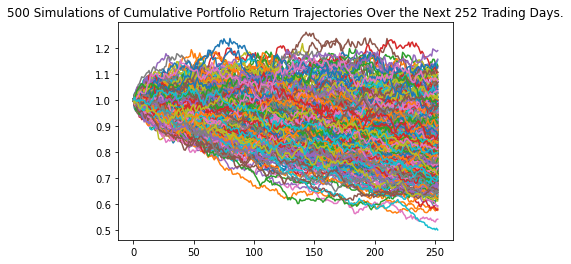

In [105]:
# Visualize the 1 year Monte Carlo simulation by creating an overlay line plot

line_plot_min_portfolio_plot = MC_min_portfolio.plot_simulation()

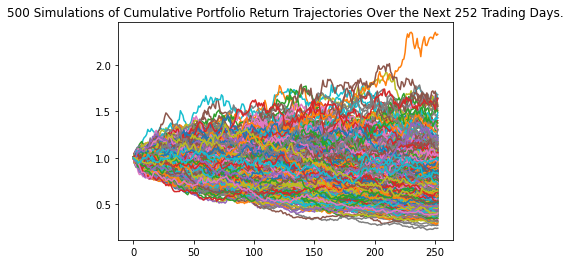

In [106]:
# Visualize the 1 year Monte Carlo simulation by creating an
# overlay line plot
line_plot_max_portfolio_plot = MC_max_portfolio.plot_simulation()

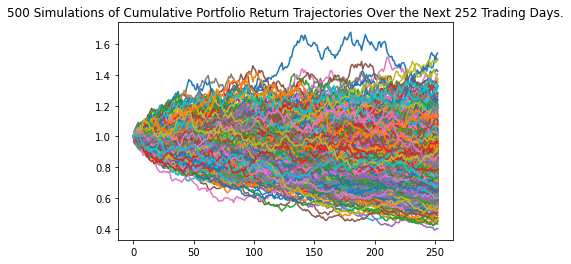

In [107]:
# Visualize the 1 year Monte Carlo simulation by creating an
# overlay line plot
line_plot_opt_sharpe_ratio_portfolio_plot = MC_opt_sharpe_ratio_portfolio.plot_simulation()

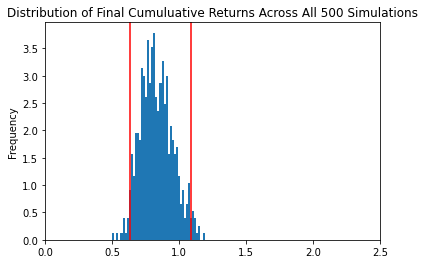

In [108]:
# Visualize the probability distribution of the 1 year Monte Carlo simulation 
# by plotting a histogram
plt.xlim([0, 2.5])
distribution_plot_min_portfolio_plot = MC_min_portfolio.plot_distribution()

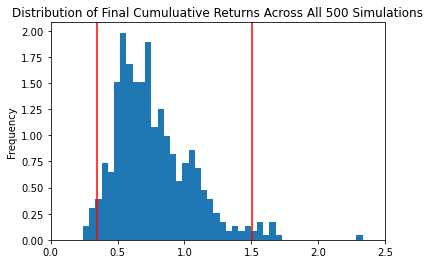

In [109]:
# Visualize the probability distribution of the 1 year Monte-Carlo simulation 
# by plotting a histogram
plt.xlim([0, 2.5])
distribution_plot_max_portfolio_plot = MC_max_portfolio.plot_distribution()

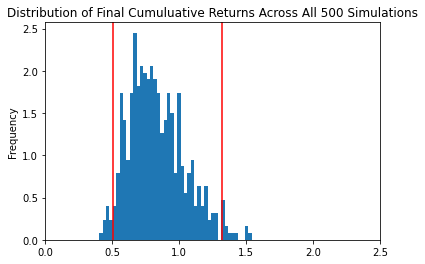

In [110]:
# Visualize the probability distribution of the 1 year Monte Carlo simulation 
# by plotting a histogram
plt.xlim([0, 2.5])
distribution_plot_opt_sharpe_ratio_portfolio_plot = MC_opt_sharpe_ratio_portfolio.plot_distribution()

In [111]:
# Generate summary statistics from the 1 year Monte-Carlo simulation results
# Save the results as a variable
table_min_portfolio_weight = MC_min_portfolio.summarize_cumulative_return()

# Review the 1 year Monte Carlo summary statistics
print(table_min_portfolio_weight)

count           500.000000
mean              0.831383
std               0.120783
min               0.500064
25%               0.743288
50%               0.818986
75%               0.905893
max               1.189497
95% CI Lower      0.631354
95% CI Upper      1.090764
Name: 252, dtype: float64


In [112]:
# Generate summary statistics from the 1 year Monte-Carlo simulation results
# Save the results as a variable
table_max_portfolio_weight = MC_max_portfolio.summarize_cumulative_return()

# Review the 1 year Monte Carlo summary statistics
print(table_max_portfolio_weight)

count           500.000000
mean              0.766361
std               0.285470
min               0.241448
25%               0.558172
50%               0.713442
75%               0.919782
max               2.330376
95% CI Lower      0.349681
95% CI Upper      1.502150
Name: 252, dtype: float64


In [113]:
# Generate summary statistics from the 1 year Monte Carlo simulation results
# Save the results as a variable
table_opt_sharpe_ratio_portfolio_weight = MC_opt_sharpe_ratio_portfolio.summarize_cumulative_return()

# Review the 1 year Monte Carlo summary statistics
print(table_opt_sharpe_ratio_portfolio_weight)

count           500.000000
mean              0.831462
std               0.207620
min               0.402923
25%               0.673331
50%               0.801296
75%               0.956112
max               1.540873
95% CI Lower      0.508929
95% CI Upper      1.318372
Name: 252, dtype: float64


In [114]:
# Print the initial investment in the portfolio
print(f"The initial investment of the portfolio is ${mpt.initial_test_investment:0.2f}")

The initial investment of the portfolio is $10000.00


In [118]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the MIN portfolio

# Get the lower and upper CI values
ci_lower_95per = table_min_portfolio_weight[8]
ci_upper_95per = table_min_portfolio_weight[9]

# Determine the lower and upper bounds of the expected cumaltiver returns
ci_lower_cumulative_return = round(ci_lower_95per * mpt.initial_test_investment, 2) 
ci_upper_cumulative_return = round(ci_upper_95per * mpt.initial_test_investment, 2)

# Print the result of your calculations
print()
print(f"There is a 95% chance that the current minimum portfolio value of ${mpt.initial_test_investment:0.2f}, will end within the range of"
      f" ${ci_lower_cumulative_return:0.2f} and ${ci_upper_cumulative_return:0.2f}.")
print(f"The actual realized value of the portfolio was ${investment_pnl_min:0.2f}")


There is a 95% chance that the current minimum portfolio value of $10000.00, will end within the range of $6313.54 and $10907.64.
The actual realized value of the portfolio was $7813.03


In [119]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the MAX portfolio

# Get the lower and upper CI values
ci_lower_95per = table_max_portfolio_weight[8]
ci_upper_95per = table_max_portfolio_weight[9]

# Determine the lower and upper bounds of the expected cumaltiver returns
ci_lower_cumulative_return = round(ci_lower_95per * mpt.initial_test_investment, 2)
ci_upper_cumulative_return = round(ci_upper_95per * mpt.initial_test_investment, 2) 

# Print the result of your calculations
print()
print(f"There is a 95% chance that the current maximum portfolio value of ${mpt.initial_test_investment:0.2f}, will end within the range of"
      f" ${ci_lower_cumulative_return:0.2f} and ${ci_upper_cumulative_return:0.2f}.")
print(f"The actual realized value of the portfolio was ${investment_pnl_max:0.2f}")


There is a 95% chance that the current maximum portfolio value of $10000.00, will end within the range of $3496.81 and $15021.50.
The actual realized value of the portfolio was $6503.36


In [120]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the OPT SHARPE RATIO portfolio

# Get the lower and upper CI values
ci_lower_95per = table_opt_sharpe_ratio_portfolio_weight[8]
ci_upper_95per = table_opt_sharpe_ratio_portfolio_weight[9]

# Determine the lower and upper bounds of the expected cumaltive returns
ci_lower_cumulative_return = round(ci_lower_95per * mpt.initial_test_investment, 2) 
ci_upper_cumulative_return = round(ci_upper_95per * mpt.initial_test_investment, 2) 

# Print the result of your calculations
print()
print(f"There is a 95% chance that the current optimal Sharpe Ratio of a given portfolio value of ${mpt.initial_test_investment:0.2f}, will end within the range of"
      f" ${ci_lower_cumulative_return:0.2f} and ${ci_upper_cumulative_return:0.2f}.")
print(f"The actual realized value of the portfolio was ${investment_pnl_opt_sharpe_ratio:0.2f}")


There is a 95% chance that the current optimal Sharpe Ratio of a given portfolio value of $10000.00, will end within the range of $5089.29 and $13183.72.
The actual realized value of the portfolio was $7590.25
